In [1]:
import os
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx

In [2]:
def compute_seg(x, y, nb=20):
    """
    a function used to compute the segment between two points
    -----------------------------------
    Parameters : 

    x : array-like obj,
    an input, d>=2

    y : array-like obj, 
    the second input

    nb : int, 
    the number of points we want to have between the two points

    Returns : 

    segment : array-like
    an array of shape d (dimension of x), nb
    ---------------------------------------
    """
    d = x.shape[0]
    segment = np.zeros((nb, d))
    points = np.linspace(start=0., stop=1., num=nb, endpoint=True)
    
    for i in range(nb):
        t = points[i]
        segment[i, :] = (1-t) * x + t * y
        
    return segment

In [3]:
n_samples = 80
n = 3*n_samples
C = 1

In [4]:
x_axis_a = np.linspace(-1.,0.8,n_samples,endpoint=True).reshape(-1,1)
x_axis_b = np.linspace(-0.2,1,n_samples,endpoint=True).reshape(-1,1)

cov_noise = np.eye(2)*0.005
cov_noise[1,1] *= 25

gaussian_noise = np.random.multivariate_normal(mean=np.zeros(2),cov=cov_noise, size=(n_samples))

y_axis_a = (1-x_axis_a**2).reshape(-1,1)
y_axis_b = (1-x_axis_b**2).reshape(-1,1)

a_group = np.hstack((x_axis_a,-np.sqrt(y_axis_a)))
b_group = np.hstack((x_axis_b,np.sqrt(y_axis_b)))

unif_noise_a = np.random.uniform(low=-0.15,high=0.15,size=(n_samples,2))
unif_noise_b = np.random.uniform(low=-0.15,high=0.15,size=(n_samples,2))

a_group += unif_noise_a
b_group += unif_noise_b

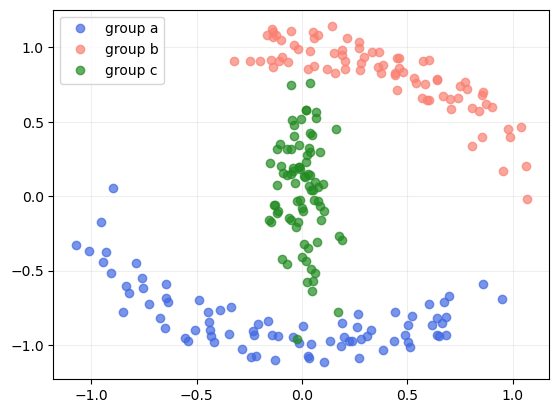

In [5]:
fig, ax = plt.subplots()
ax.plot(a_group[:,0],a_group[:,1],'o',color='royalblue',alpha=0.7,label='group a')
ax.plot(b_group[:,0],b_group[:,1],'o',color='salmon',alpha=0.7,label='group b')
ax.plot(gaussian_noise[:,0], gaussian_noise[:,1],'o', color='forestgreen',alpha=0.7,label='group c')
ax.grid(alpha=0.2)
ax.legend()

In [6]:
whole_data = np.vstack((a_group,b_group,gaussian_noise))

In [7]:
clf = OneClassSVM(gamma=48).fit(whole_data)

adj_mat = np.zeros((n,n))

for i in tqdm(range(n)):
    for j in range(i,n):
        segment = compute_seg(x=whole_data[i,:],y=whole_data[j,:])
        pred_temp = clf.predict(segment)
        if -1 in pred_temp:
            adj_mat[i,j] = 0
        else:
            adj_mat[i,j] = 1
adj_mat = adj_mat + adj_mat.T
for i in range(n):
    adj_mat[i,i] = 0

G = nx.from_numpy_array(adj_mat)

clusters = list(nx.connected_components(G))
print('number of clusters detected', len(clusters))

sorted_clusters = sorted(clusters, key=len, reverse=True)
print(f"largest cluster: {len(sorted_clusters[0])}")

#a quick preview of how we are doing
top_5_clusters = sorted_clusters[:5]
for i, cluster in enumerate(top_5_clusters, start=1):
    print(f"size of cluster {i}: {len(cluster)}")

100%|██████████| 240/240 [00:06<00:00, 37.48it/s] 

number of clusters detected 128
largest cluster: 44
size of cluster 1: 44
size of cluster 2: 43
size of cluster 3: 18
size of cluster 4: 7
size of cluster 5: 5


In [8]:
xx, yy = np.meshgrid(np.linspace(-1.5,1.5,200), np.linspace(-1.5,1.5,200))
results_plot = np.empty(200**2)
for i in tqdm(range(200**2)):
    results_plot[i] = clf.decision_function(np.c_[xx.ravel(), yy.ravel()][i,:].reshape(1,-1))[0]
Z = results_plot
Z = Z.reshape(xx.shape)

100%|██████████| 40000/40000 [00:06<00:00, 5958.37it/s]


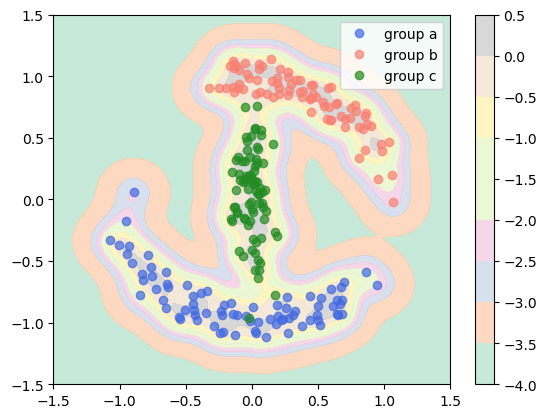

In [9]:
plt.contourf(xx, yy, Z, alpha=0.75, cmap=plt.cm.Pastel2)
plt.plot(a_group[:,0],a_group[:,1],'o',color='royalblue',alpha=0.7,label='group a')
plt.plot(b_group[:,0],b_group[:,1],'o',color='salmon',alpha=0.7,label='group b')
plt.plot(gaussian_noise[:,0], gaussian_noise[:,1],'o', color='forestgreen',alpha=0.7,label='group c')
plt.legend()
plt.colorbar()
plt.show()

In [10]:
actual_path = os.getcwd()
os.chdir(f'{actual_path}/data')
original_data = pd.read_csv('OnlineNewsPopularity.csv')
os.chdir(actual_path)

full_names = []
for name in list(original_data.columns):
    temp_name = name.split()
    full_names.append(temp_name[0])

original_data.columns = full_names

original_data.columns

original_data.drop(['url','timedelta'],axis=1,inplace=True)

original_data['shares'].describe()
n = original_data.shape[0]


original_data['pop_cat'] = original_data['shares'].copy()
data = original_data.copy()
for i in range(n):
    if data.loc[i,'shares'] < 946.:
        data.loc[i,'pop_cat'] = 0
    elif data.loc[i,'shares'] < 1400. :
        data.loc[i,'pop_cat'] = 1
    elif data.loc[i,'shares'] < 2800. :
        data.loc[i,'pop_cat'] = 2
    elif data.loc[i,'shares'] >= 2800. :
        data.loc[i,'pop_cat'] = 3
data = data[data['pop_cat'].isin([0,3])]

In [11]:
target = data['pop_cat'].copy()

In [12]:
#we center the data for the pca (as done in the article)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.drop('pop_cat', axis=1))


n_components = 4
pca = PCA(n_components=n_components)

principal_components = pca.fit_transform(data_scaled)
columns = [f"PC{i+1}" for i in range(n_components)]
principal_df = pd.DataFrame(data=principal_components, columns=columns)


print("part of variance explained by every component :", pca.explained_variance_ratio_)


print("total variance explained :", np.sum(pca.explained_variance_ratio_))

d = principal_df.shape[1]
principal_df = np.hstack((principal_df,target.to_numpy().reshape(-1,1)))
principal_df_whole = principal_df.copy()
principal_df = pd.DataFrame(principal_df)

part of variance explained by every component : [0.08321758 0.06869974 0.06231448 0.05094091]
total variance explained : 0.26517270456829545


In [13]:
#we rename the columns (more of a commidity than a necessity)
colnames = []
for i in range(4):
    colnames.append(f'pc_{i}')
colnames.append('target')
principal_df.columns = colnames
principal_df = principal_df.groupby('target', group_keys=False).apply(lambda x: x.sample(frac=0.05,random_state=87876899))
target = principal_df['target'].copy()
print(principal_df.shape)
n = principal_df.shape[0]

(994, 5)


/tmp/ipykernel_8180/3040409924.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  principal_df = principal_df.groupby('target', group_keys=False).apply(lambda x: x.sample(frac=0.05,random_state=87876899))


In [14]:
principal_df.drop('target',axis=1,inplace=True)

In [15]:
clf = OneClassSVM(gamma=0.03,nu=0.05)
clf.fit(principal_df.to_numpy())

OneClassSVM(gamma=0.03, nu=0.05)

In [16]:
adj_mat = np.zeros((n,n))
pdfnp = principal_df.to_numpy()

for i in tqdm(range(n)):
    for j in range(i,n):
        segment = compute_seg(x=pdfnp[i,:],y=pdfnp[j,:])
        pred_temp = clf.predict(segment)
        if -1 in pred_temp:
            adj_mat[i,j] = 0
        else:
            adj_mat[i,j] = 1

100%|██████████| 994/994 [01:20<00:00, 12.31it/s] 


In [17]:
adj_mat = adj_mat + adj_mat.T
for i in range(n):
    adj_mat[i,i] = 0

In [18]:
G = nx.from_numpy_array(adj_mat)

clusters = list(nx.connected_components(G))
print('number of clusters detected', len(clusters))

number of clusters detected 48


In [19]:
sorted_clusters = sorted(clusters, key=len, reverse=True)
print(f"largest cluster: {len(sorted_clusters[0])}")

#a quick preview of how we are doing
top_5_clusters = sorted_clusters[:5]
for i, cluster in enumerate(top_5_clusters, start=1):
    print(f"size of cluster {i}: {len(cluster)}")

largest cluster: 947
size of cluster 1: 947
size of cluster 2: 1
size of cluster 3: 1
size of cluster 4: 1
size of cluster 5: 1
